# Appendix B

## Evolution of Bell State for given System Hamiltonian on IBM Hardware
Similar to Appendix A, we create a circuit using Qiskit to initialize a Bell pair. Then, we add the system Hamiltonian to the circuit using qiskit's [HamiltonianGate](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.HamiltonianGate.) function. This gate resolves to a unitary $U(t) = e^{(-iHt)}$ that evolves in time $t$. We measure this circuit over arbitrary time, and obtain the resulting density matrices by performing **state tomography**. Finally, we compute and plot the **concurrence** for all resulting states in time $t_{0}$ to $t$.
* Our intial state is Bell State $\beta_{11} = (\ket{10} - \ket{01})/\sqrt(2)$.
* The system Hamiltonian for two qubits interacting with each other is given by $H_{S} = (\omega_{0}/2) \sigma_{z}^{(1)} + (\omega_{0}/2) \sigma_{z}^{(2)} + \Omega(\sigma_{+}^{(1)}\sigma_{-}^{(2)} + \sigma_{-}^{(1)}\sigma_{+}^{(2)})$

### Imports and Saving Default Account

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import execute_job

from config import api_key
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit.quantum_info import DensityMatrix, SparsePauliOp, concurrence
from qiskit.visualization import (
    plot_bloch_multivector,
    plot_histogram,
    plot_state_qsphere,
    plot_state_city
)
from qiskit_experiments.library import StateTomography
from qiskit.compiler import transpile
from qiskit.providers.fake_provider import FakeQasmBackend, GenericBackendV2
from qiskit.circuit.library import HamiltonianGate


In [3]:
## Save an IBM Quantum account as your default account, and Load saved credentials

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    instance="usc/phys550/phys550",
    token=api_key,
    set_as_default=True,
    overwrite=True,
)
service = QiskitRuntimeService()

### Creating the Quantum Circuit

#### Generating an Entangled Pair - Bell State $\beta_{11}$

Circuit for generating Bell State β₁₁:


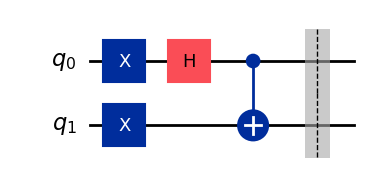

In [4]:
## Quantum circuit for generating Bell state (11)

circ = QuantumCircuit(2)
circ.x([0, 1])  # Apply X gate to the second qubit
circ.h(0)  # Apply Hadamard gate to the first qubit
circ.cx(0, 1)  # Apply CNOT gate with the first qubit as control and the second as target
circ.barrier()

# Storing the intitial bell state
initial_state = DensityMatrix.from_instruction(circ)

print('Circuit for generating Bell State \u03B2\u2081\u2081:')
circ.draw('mpl')

Visualization of Initial State β₁₁ at time = t₀:


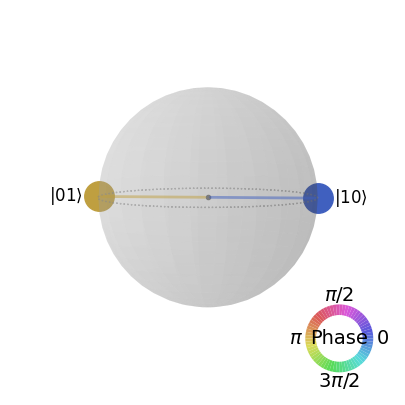

In [5]:
## Print qSpheres for Bell state (11)

print('Visualization of Initial State \u03B2\u2081\u2081 at time = t\u2080:')
plot_state_qsphere(state=initial_state, figsize=(5, 5))

#### Appending System Hamiltonian $H_{S}$ to the Circuit

Hamiltonian: 
[[ 2.   0.   0.   0. ]
 [ 0.   0.   0.1  0. ]
 [ 0.   0.1  0.   0. ]
 [ 0.   0.   0.  -2. ]]

Circuit with Hamiltonian:
     ┌───┐┌───┐      ░ ┌──────────────┐ ░ 
q_0: ┤ X ├┤ H ├──■───░─┤0             ├─░─
     ├───┤└───┘┌─┴─┐ ░ │  Hamiltonian │ ░ 
q_1: ┤ X ├─────┤ X ├─░─┤1             ├─░─
     └───┘     └───┘ ░ └──────────────┘ ░ 

Decomposed circuit:


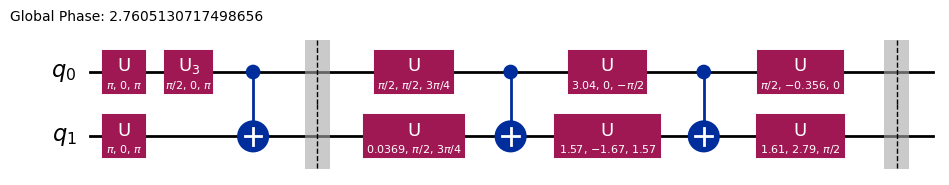

In [6]:
## Define Hamiltonian components using Pauli matrices

omega = 1       # Energy level of the qubits
bomega = 0.1    # Coupling strength
t = 1        # Time for evolution

# Define H_S and H_I with proper scalar multiplication
H_S = np.array([[2,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,-2]]) * (omega)
H_I = np.array([[0,0,0,0],[0,0,2,0],[0,2,0,0],[0,0,0,0]]) * (bomega/2)

# Sum H_S and H_I to get the total Hamiltonian H
H = H_S + H_I
print('Hamiltonian: \n' + str(H))

# Apply Hamiltonian Gate
hamiltonian_gate = HamiltonianGate(H, t)
qc = circ.copy()
qc.append(hamiltonian_gate, [0, 1])
qc.barrier()
print('\nCircuit with Hamiltonian:\n' + str(qc.draw()))
print('\nDecomposed circuit:')
qc.decompose(reps=2).draw('mpl')

### Running circuit for time $t$

#### State tomography on IBM Fake Backend (Noisy)

In [7]:
## Measuring hamiltonian circuit for arbitrary time

noise_list = []
shots = 100
time = np.arange(1,30,2,dtype=float)
backend = GenericBackendV2(num_qubits=2)
# backend = service.backend("ibmq_qasm_simulator")

for t in time:
    hamiltonian_gate = HamiltonianGate(H, t)
    temp = circ.copy()
    temp.append(hamiltonian_gate, [0, 1])
    temp.barrier()
    qstexp = StateTomography(qc)
    qstdata = qstexp.run(backend).block_for_results() # In StateTomography, each circuit runs 9 times
    result = qstdata.analysis_results("state").value
    noise_list.append(
        {
            "time": t,
            "tomo_result": qstdata,
            "density_matrix": result
        }
    )
    
fake_data = pd.DataFrame(noise_list)

Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['id', 'measure', 'cx', 'sx', 'x']>)) that is different than the current backend (<qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x0000024C7EBCEAB0>). The new backend will be used, but service is not changed if one already exists.
Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['id', 'measure', 'cx', 'sx', 'x']>)) that is different than the current backend (<qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x0000024C7EBCEAB0>). The new backend will be used, but service is not changed if one already exists.
Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['id', 'measure', 'cx', 'sx', 'x']>)) that is different than the current backend (<qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x0000024C7EBCEAB0>). 

#### State Tomography Jobs on Real IBM Backend

In [8]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_cusco')>,
 <IBMBackend('ibm_nazca')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_stabilizer')>]

In [9]:
## Measuring hamiltonian circuit for arbitrary time on real IBM hardware

data_list = []
shots = 100
time = np.arange(1,30,2,dtype=float)
backend = service.backend("ibm_torino")

for t in time:
    hamiltonian_gate = HamiltonianGate(H, t)
    temp = circ.copy()
    temp.append(hamiltonian_gate, [0, 1])
    temp.barrier()
    qstexp = StateTomography(qc)
    qstdata = qstexp.run(backend).block_for_results() # In StateTomography, each circuit runs 9 times
    result = qstdata.analysis_results("state").value
    data_list.append(
        {
            "time": t,
            "tomo_result": qstdata,
            "density_matrix": result
        }
    )
    
data = pd.DataFrame(data_list)

In [ ]:
print(data)

### Compute Concurrence and Plot the Results - Concurrence vs. Time

In [ ]:
### Compute Concurrence and Plot the Results
fake_conc = []
conc_list = []
times = np.concatenate(([0.0], time))

# Concurrence of all states from fake noisy backend
fake_conc.append(concurrence(initial_state))
for dm in fake_data["density_matrix"]:
    fake_conc.append(concurrence(dm))
print('Concurrences from fake backend: ' + str(fake_conc))


# Concurrence of all resulting states from real hardware
conc_list.append(concurrence(initial_state))
for dm in data["density_matrix"]:
    conc_list.append(concurrence(dm))
print('Concurrences from IBM hardware' + str(conc_list))
final_state = dm

# Plotting Concurrence vs Circuit Depth

plt.title("Concurrence vs Circuit Depth (Initial State - \u03B2\u2081\u2081)")
plt.xlabel("Time $t$ (quantum seconds)")
plt.ylabel("Concurrence")
plt.plot(times, conc_list, marker='.', label='ibm_torino')
plt.plot(times, fake_conc, marker='.', label='GenericBackendV2')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
## Print qSpheres for final state after time t

print("Visualization of State after time 't':")
plot_state_qsphere(state=final_state, figsize=(5, 5))

In [ ]:
## Visualize Density Matrice of final state

plot_state_city(final_state, title="Density Matrix for Final State after time 't'")